# Sample solutions

In [1]:
%matplotlib inline
%load_ext memory_profiler
import numpy as np
from scipy import sparse
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib as mpl
from yellowbrick.style import rcmod
from scipy.stats import spearmanr
from memory_profiler import profile

In [3]:
# Yellowbrick changes the plotting settings, reset to default here
rcmod.reset_orig()

# Problem 1

1. Load the data

In [5]:
X = np.load("data/p1/X.npy")
y = np.load("data/p1/y.npy")

In [4]:
# 511 cells, 45768 genes
print(X.shape)

(511, 45768)


In [6]:
# Largest entry of first column
np.max(X[:,0])

11.941397591320595

2. Log transform

In [7]:
# Log 
X_log = np.log2(X + 1)

In [7]:
# Largest entry of first column
print(np.max(X_log[:,0]))

3.6939215228197613


3. Full PCA, raw vs transformed data

In [8]:
%%timeit -n 1 -r 1
%%memit -r 1
pca = PCA().fit(X)
pca_log = PCA().fit(X_log)

peak memory: 1429.69 MiB, increment: 951.43 MiB
10.6 s Â± 0 ns per loop (mean Â± std. dev. of 1 run, 1 loop each)


In [10]:
# Percentage of variance explained by first component
print("First component raw:", pca.explained_variance_ratio_[0])
print("First component log:", pca_log.explained_variance_ratio_[0])

First component raw: 0.42779670983572665
First component log: 0.13887564870826177


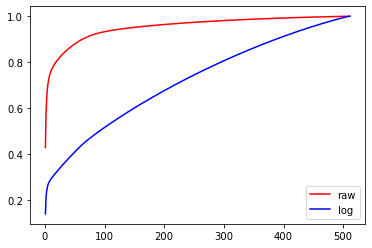

In [11]:
# Cumulative variance explained plots
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca.explained_variance_ratio_), color="red", label="raw")
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca_log.explained_variance_ratio_), color="blue", label="log")
plt.legend()
plt.show()

In [12]:
# 85% variance cutoffs
print("Raw:", np.where(np.cumsum(pca.explained_variance_ratio_) >= .85)[0][0] + 1)
print("Log:", np.where(np.cumsum(pca_log.explained_variance_ratio_) >= .85)[0][0] + 1)

Raw: 36
Log: 339


4. Plotting without visualization techniques

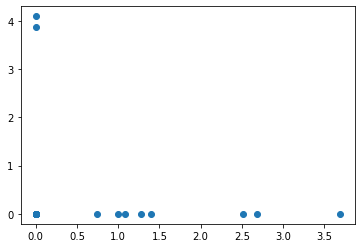

In [13]:
# Nothing informative!
plt.scatter(X_log[:,0],X_log[:,1])

5. PCA visualization

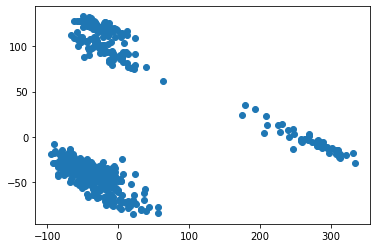

In [14]:
# Three visually distinct clusters. Could potentially argue for 4 or 5 as well, but these are not well-separated
z = pca_log.transform(X_log)
plt.scatter(z[:,0],z[:,1])

6. MDS (sklearn version is nonlinear)

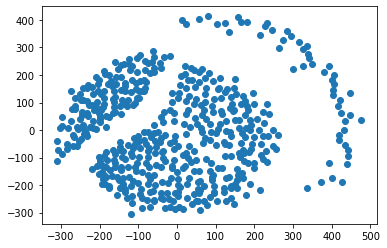

In [15]:
# We still see 3 distinct clusters.
mds=MDS(n_components=2).fit_transform(X_log)
plt.scatter(mds[:,0],mds[:,1])

7. T-SNE

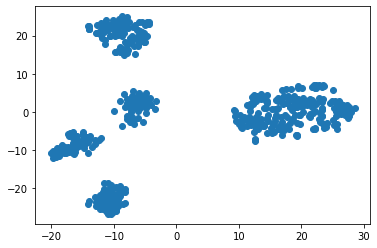

In [16]:
# Emergence of at least 5 clusters. 
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1])

8. K-Means

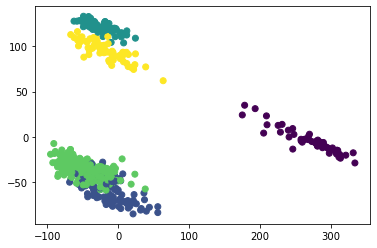

In [17]:
# 5 clusters: PCA plot
kmeans = KMeans(5, tol=1e-6)
kmeans.fit(z[:,0:50])
plt.scatter(z[:,0],z[:,1], c=kmeans.labels_)

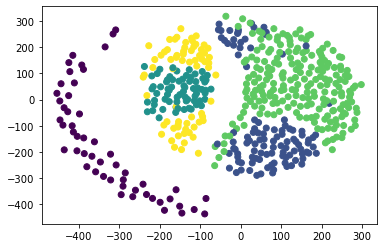

In [24]:
# 5 clusters: MDA with K means plot
plt.scatter(mds[:,0],mds[:,1],c=kmeans.labels_)

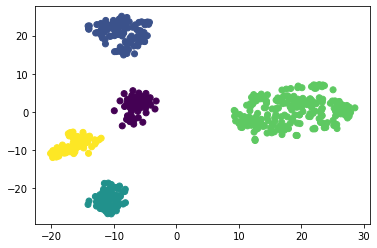

In [18]:
# T-SNE plot
plt.scatter(z_tsne[:,0],z_tsne[:,1], c=kmeans.labels_)

9. Elbow method.

Num clusters 2 Inertia: 9520809.578746
Num clusters 3 Inertia: 7257882.201193228
Num clusters 4 Inertia: 6202929.841899466
Num clusters 5 Inertia: 5801585.180913827
Num clusters 6 Inertia: 5561682.44813587
Num clusters 7 Inertia: 5398373.909889216
Num clusters 8 Inertia: 5244358.318708705
Num clusters 9 Inertia: 5218512.976946919


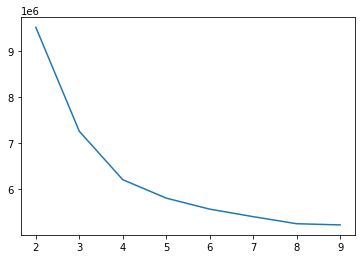

In [19]:
# Would select 3, 4, or 5 clusters
all_kmeans = [i for i in range(8)]
for i in range(8):
    cur_kmeans = KMeans(i+2)
    cur_kmeans.fit(z[:,0:50])
    print("Num clusters", i+2, "Inertia:", cur_kmeans.inertia_)
    all_kmeans[i] = cur_kmeans
plt.plot([i+2 for i in range(8)], [all_kmeans[i].inertia_ for i in range(8)])

10. Hierarchical clustering: Dendrogram in R script

11. MDS on cluster means. Confirms 3 groups, one with 1 cluster and two with 2 clusters each. Accurate representation of distances - one cluster is far away from others, indicating a different type of cell. But T-SNE consistently puts it in the middle of the plot.

In [20]:
# MDS on kmeans cluster means
cmeans = np.zeros((5,X_log.shape[1]))
for c in range(5):
    cmeans[c] = np.mean(X_log[np.where(kmeans.labels_==c)[0]],axis=0)

breaking at iteration 98 with stress 6342.534572033932
breaking at iteration 166 with stress 6080.44123860059
breaking at iteration 95 with stress 6342.512244781481
breaking at iteration 105 with stress 6079.000721967379


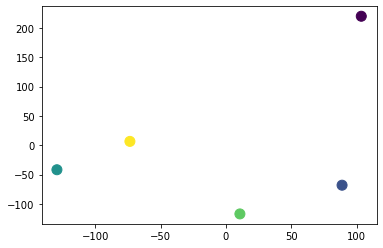

In [21]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(cmeans)
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1],c=[0,1,2,3,4],s=100)

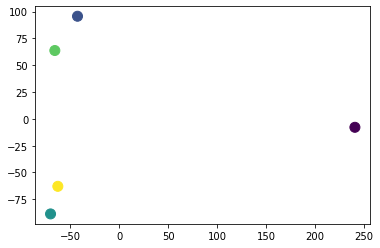

In [22]:
# PCA on cluster means
z_means = PCA(2).fit_transform(cmeans)
plt.scatter(z_means[:,0],z_means[:,1],c=[0,1,2,3,4],s=100)

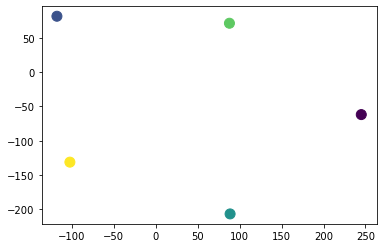

In [26]:
# Emergence of at least 5 clusters. 
z_means_tsne = TSNE(n_components=2,perplexity=40).fit_transform(cmeans)
plt.scatter(z_means_tsne[:,0],z_means_tsne[:,1],c=[0,1,2,3,4],s=100)

12. PCA/T-SNE on Raw Data

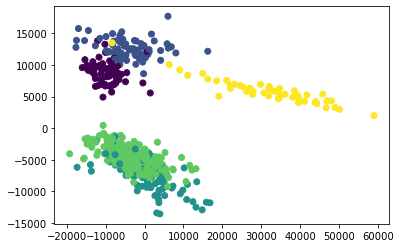

In [32]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1],c=y)

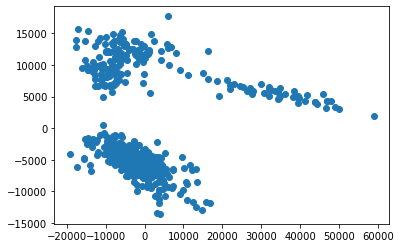

In [33]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1])

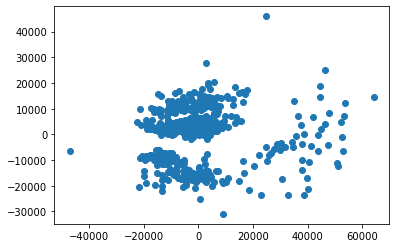

In [31]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(z[:,0:50])
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1])

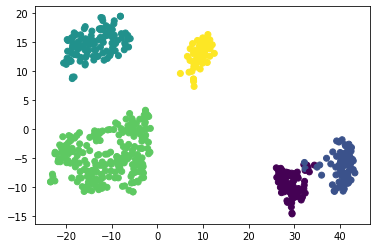

In [28]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=y)

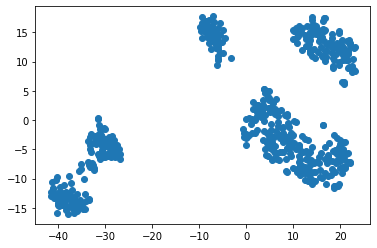

In [34]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1])